# Begin

## Loading necessary libraries

In [1]:
#Importing necessary libraries
import numpy as np
import pandas as pd
import re
import os
import pathlib
import plotly.express as pe
import plotly.figure_factory as ff
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sn
import warnings
from zipfile import ZipFile
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, precision_recall_curve, roc_curve, confusion_matrix, recall_score, precision_score
from utils import *

warnings.filterwarnings("ignore")

pd.set_option("precision", 4)
pd.set_option("max_columns",30)

## Data files

In [2]:
#Files in the train_set
train_path = os.path.join(os.curdir,"Train")
train_dir = pathlib.Path(train_path)

for file in train_dir.iterdir():
        print(file.stem+file.suffix)

Train
__MACOSX


We have subfolders in the Train folder. Now we will look into the Train subfolder.

In [3]:
#Looking into the train folder
train_path = os.path.join(train_path,"Train")
train_dir = pathlib.Path(train_path)

for file in train_dir.iterdir():
    if file.is_file():
        print(file.stem+file.suffix)

.DS_Store
data_dict.xlsx
train_bureau.xlsx
train_Data.xlsx


In [4]:
#Files in the test set
test_path = os.path.join(os.curdir, "Test")
test_dir = pathlib.Path(test_path)

for file in test_dir.iterdir():
    if file.is_file():
        print(file.stem+file.suffix)

test_bureau.xlsx
test_Data.xlsx


## Loading data

In [5]:
train_bureau = pd.read_excel(io = train_path+"\\train_bureau.xlsx")
train_data = pd.read_excel(io = train_path+"\\train_Data.xlsx")
data_dict = pd.read_excel(io = train_path+"\\data_dict.xlsx")

In [6]:
test_bureau = pd.read_excel(io = test_path+"\\test_bureau.xlsx")
test_data = pd.read_excel(io = test_path + "\\test_Data.xlsx")

In [7]:
train_bureau.head()

,ID,SELF-INDICATOR,MATCH-TYPE,ACCT-TYPE,CONTRIBUTOR-TYPE,DATE-REPORTED,OWNERSHIP-IND,ACCOUNT-STATUS,DISBURSED-DT,CLOSE-DT,LAST-PAYMENT-DATE,CREDIT-LIMIT/SANC AMT,DISBURSED-AMT/HIGH CREDIT,INSTALLMENT-AMT,CURRENT-BAL,INSTALLMENT-FREQUENCY,OVERDUE-AMT,WRITE-OFF-AMT,ASSET_CLASS,REPORTED DATE - HIST,DPD - HIST,CUR BAL - HIST,AMT OVERDUE - HIST,AMT PAID - HIST,TENURE
0,1,False,PRIMARY,Overdraft,NAB,2018-04-30,Individual,Delinquent,2015-10-05,NaN,2018-02-27,NaN,"37,352",NaN,"37,873",NaN,"37,873",0.0,Standard,"20180430,20180331,",030000,"37873,12820,","37873,,",",,",NaN
1,1,False,PRIMARY,Auto Loan (Personal),NAB,2019-12-31,Individual,Active,2018-03-19,NaN,2019-12-19,NaN,"44,000","1,405/Monthly","20,797",F03,NaN,0.0,Standard,"20191231,20191130,20191031,20190930,20190831,2...",0000000000000000000000000000000000000000000000...,"20797,21988,23174,24341,25504,26648,27780,2891...",",,,,,,,,,,,,,,,,,,,,1452,,",",,,,,,,,,,,,,,,,,,,,,,",36.0
2,1,True,PRIMARY,Tractor Loan,NBF,2020-01-31,Individual,Active,2019-08-30,NaN,NaT,NaN,"1,45,000",NaN,"1,16,087",NaN,0,0.0,NaN,"20200131,20191231,20191130,20191031,20190930,2...",000000000000000000,"116087,116087,145000,145000,145000,145000,","0,0,0,0,0,0,",",,,,,,",NaN
3,1,True,PRIMARY,Auto Loan (Personal),NBF,2017-09-30,Individual,Closed,2013-09-27,2017-09-21 00:00:00,NaT,NaN,"3,00,000",NaN,0,NaN,0,0.0,NaN,"20170930,20170801,20170731,20170630,20170531,2...",000DDD0270260270260270240270270000320000000000...,"0,,15925,23754,31494,39147,46713,54194,61590,6...","0,,1014,1014,1014,1014,1014,1014,1014,983,0,92...",",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,",NaN
4,1,True,PRIMARY,Tractor Loan,NBF,2016-02-29,Individual,Closed,2012-02-10,2016-02-01 00:00:00,NaT,NaN,"2,75,000",NaN,0,NaN,0,0.0,NaN,"20160229,20160131,20151231,20151130,20151031,2...",0000000000000000000000000000000000000000000000...,"0,0,23658,23321,22989,46321,45662,45012,68030,...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...",",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,",NaN


In [8]:
train_bureau.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 560844 entries, 0 to 560843
Data columns (total 25 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   ID                         560844 non-null  int64         
 1   SELF-INDICATOR             560844 non-null  bool          
 2   MATCH-TYPE                 560844 non-null  object        
 3   ACCT-TYPE                  560844 non-null  object        
 4   CONTRIBUTOR-TYPE           560844 non-null  object        
 5   DATE-REPORTED              557161 non-null  datetime64[ns]
 6   OWNERSHIP-IND              560844 non-null  object        
 7   ACCOUNT-STATUS             560844 non-null  object        
 8   DISBURSED-DT               528694 non-null  datetime64[ns]
 9   CLOSE-DT                   309086 non-null  object        
 10  LAST-PAYMENT-DATE          241561 non-null  datetime64[ns]
 11  CREDIT-LIMIT/SANC AMT      15159 non-null   object  

In [9]:
train_data.head()

,ID,Frequency,InstlmentMode,LoanStatus,PaymentMode,BranchID,Area,Tenure,AssetCost,AmountFinance,DisbursalAmount,EMI,DisbursalDate,MaturityDAte,AuthDate,AssetID,ManufacturerID,SupplierID,LTV,SEX,AGE,MonthlyIncome,City,State,ZiPCODE,Top-up Month
0,1,Monthly,Arrear,Closed,PDC_E,1,NaN,48,450000,275000.0,275000.0,24000.0,2012-02-10,2016-01-15,2012-02-10,4022465,1568,21946,61.11,M,49.0,35833.33,RAISEN,MADHYA PRADESH,464993.0,> 48 Months
1,2,Monthly,Advance,Closed,PDC,333,BHOPAL,47,485000,350000.0,350000.0,10500.0,2012-03-31,2016-02-15,2012-03-31,4681175,1062,34802,70.00,M,23.0,666.67,SEHORE,MADHYA PRADESH,466001.0,No Top-up Service
2,3,Quatrly,Arrear,Active,Direct Debit,1,NaN,68,690000,519728.0,519728.0,38300.0,2017-06-17,2023-02-10,2017-06-17,25328146,1060,127335,69.77,M,39.0,45257.00,BHOPAL,MADHYA PRADESH,462030.0,12-18 Months
3,7,Monthly,Advance,Closed,Billed,125,GUNA,48,480000,400000.0,400000.0,11600.0,2013-11-29,2017-11-10,2013-11-29,13021591,1060,25094,80.92,M,24.0,20833.33,ASHOK NAGAR,MADHYA PRADESH,473335.0,> 48 Months
4,8,Monthly,Arrear,Closed,Billed,152,BILASPUR,44,619265,440000.0,440000.0,15000.0,2011-12-08,2015-07-05,2011-12-08,3291320,1046,21853,71.05,M,56.0,27313.67,BILASPUR,CHATTISGARH,495442.0,36-48 Months


In [10]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128655 entries, 0 to 128654
Data columns (total 26 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   ID               128655 non-null  int64         
 1   Frequency        128655 non-null  object        
 2   InstlmentMode    128655 non-null  object        
 3   LoanStatus       128655 non-null  object        
 4   PaymentMode      128655 non-null  object        
 5   BranchID         128655 non-null  int64         
 6   Area             117002 non-null  object        
 7   Tenure           128655 non-null  int64         
 8   AssetCost        128655 non-null  int64         
 9   AmountFinance    128655 non-null  float64       
 10  DisbursalAmount  128655 non-null  float64       
 11  EMI              128655 non-null  float64       
 12  DisbursalDate    128655 non-null  datetime64[ns]
 13  MaturityDAte     128654 non-null  datetime64[ns]
 14  AuthDate         128

In [11]:
data_dict.head()

,Demography Table,Unnamed: 1,Unnamed: 2,Bureau Data,Unnamed: 4,Unnamed: 5,CONTRIBUTOR ID,Bank Name,Unnamed: 8,Account Type,Description
0,ID,Agreement ID (Dummy Value),NaN,ID,Agreement NO (Dummy),NaN,NBF,NBFC,NaN,A01,Auto Loan (Personal)
1,Frequency,"Frequency of the loan payment, It can be month...",NaN,SELF-INDICATOR,This field implies whether Tradeline belong to...,NaN,COP,CO-OPERATIVE BANK,NaN,A02,Auto Overdraft
2,InstlmentMode,It can be either advance or an arrear while op...,NaN,MATCH-TYPE,Type of match for Primary / Secondary or In ot...,NaN,MFI,NGO-MFI,NaN,A03,Two-Wheeler Loan
3,LoanStatus,Active Or closed Account at this point of time,NaN,ACCT-TYPE,This field implies an account type assigned by...,NaN,HFC,HOUSING FINANCE COMPANY,NaN,A04,Commercial Vehicle Loan
4,PaymentMode,Payement Mode at the start of loan. It can be ...,NaN,CONTRIBUTOR-TYPE,"Whether it’s a government bank, private bank, ...",NaN,RRB,REGIONAL RURAL BANK,NaN,A05,Commercial Equipment Loan


In [13]:
#Glance at the numeric columns in the dataset
train_data.describe([0.25,0.5, 0.75,0.95])

,ID,BranchID,Tenure,AssetCost,AmountFinance,DisbursalAmount,EMI,AssetID,ManufacturerID,SupplierID,LTV,AGE,MonthlyIncome,ZiPCODE
count,128655.00,128655.00,128655.00,1.29e+05,1.29e+05,1.29e+05,128655.00,1.29e+05,128655.00,128655.00,128655.00,128596.00,1.28e+05,128283.00
mean,70965.33,166.29,42.46,5.55e+05,3.48e+05,3.48e+05,55072.76,1.64e+07,1171.33,56551.23,59.13,40.66,5.03e+04,427931.10
std,41762.78,115.84,23.53,1.08e+05,1.06e+05,1.05e+05,28910.11,9.54e+06,257.79,36399.36,15.54,11.71,1.72e+06,175704.36
min,1.00,1.00,5.00,2.00e+05,5.00e+04,2.89e+03,0.00,4.22e+05,1019.00,5879.00,-1.38,18.00,0.00e+00,110000.00
25%,34408.50,50.00,36.00,5.00e+05,2.90e+05,2.90e+05,32500.00,9.44e+06,1046.00,24093.00,49.14,31.00,2.50e+04,304804.00
50%,70988.00,152.00,36.00,5.51e+05,3.50e+05,3.50e+05,59700.00,1.51e+07,1062.00,39146.00,60.78,40.00,3.58e+04,458553.00
75%,106549.50,274.00,48.00,6.11e+05,4.10e+05,4.10e+05,73800.00,2.53e+07,1186.00,87034.00,70.59,49.00,5.00e+04,521131.00
95%,136475.30,340.00,60.00,7.00e+05,5.04e+05,5.03e+05,97950.00,3.03e+07,1568.00,129070.00,81.82,61.00,9.29e+04,752100.90
max,143395.00,424.00,501.00,2.25e+06,1.31e+06,1.31e+06,460000.00,3.71e+07,3473.00,145518.00,100.00,90.00,6.17e+08,855456.00


<b>Observations</b>
- There are outliers present in the dataset as can be observed from the maximum values of features such as tenure, financed amount, LTV, EMI, etc.<br><br>

In [14]:
#Glance at the object columns in the dataset
train_data.select_dtypes(include = "object" ).describe()

,Frequency,InstlmentMode,LoanStatus,PaymentMode,Area,SEX,City,State,Top-up Month
count,128655,128655,128655,128655,117002,128596,117399,128655,128655
unique,4,2,2,11,92,2,488,22,7
top,Half Yearly,Arrear,Closed,Direct Debit,LUCKNOW,M,NALGONDA,MADHYA PRADESH,No Top-up Service
freq,76248,122349,94457,31766,9337,122144,2231,19122,106677


<b>Observations</b>
- The cardinality of the city column is too high which will lead to explosion in the number of dimensions. Even though the number are small for the Area column we still do not prefer using it as a input feature.
- Max number of loans were taken by people from Madhya Pradesh.
- More than 80% of the customers did not go for Top-Up Service.
- More than 90% of the customers chose Arrears as the preferred mode for making EMI installments in comparison to others who chose to pay in advance.
- More than 90% of the customers or loan applicants were Males.

In [15]:
#Glance at the datatime columns in the dataset
train_data.select_dtypes(include = "datetime" ).describe()

,DisbursalDate,MaturityDAte,AuthDate
count,128655,128654,128655
unique,2837,980,2711
top,2017-10-31 00:00:00,2018-06-10 00:00:00,2017-10-31 00:00:00
freq,1287,2298,1295
first,2010-02-01 00:00:00,2010-11-15 00:00:00,2010-02-03 00:00:00
last,2019-11-23 00:00:00,2059-08-10 00:00:00,2019-11-23 00:00:00


The data provided here is for the loans authorized from the year 2010 till 2019 end.

## Joining the train_data and train_bureau datasets

In [13]:
def join_frames(frame_bureau, frame_data, new_frame = pd.DataFrame()):
    #Renaming the Disbursal date column in train_bureau for merging
    frame_bureau.rename(columns={"DISBURSED-DT": "DisbursalDate"}, inplace = True)

    #Merging the two frames on ID and Disbursal date
    new_frame = pd.merge(frame_data, frame_bureau,how = "left", on = ["ID", "DisbursalDate"], validate = "one_to_many")

    #Dropping the duplicates on ID from the main dataframe
    new_frame.drop_duplicates("ID", inplace =True)
    
    return new_frame

In [14]:
main = join_frames(train_bureau, train_data)
test = join_frames(test_bureau, test_data)

In [15]:
main.head()

,ID,Frequency,InstlmentMode,LoanStatus,PaymentMode,BranchID,Area,Tenure,AssetCost,AmountFinance,DisbursalAmount,EMI,DisbursalDate,MaturityDAte,AuthDate,...,LAST-PAYMENT-DATE,CREDIT-LIMIT/SANC AMT,DISBURSED-AMT/HIGH CREDIT,INSTALLMENT-AMT,CURRENT-BAL,INSTALLMENT-FREQUENCY,OVERDUE-AMT,WRITE-OFF-AMT,ASSET_CLASS,REPORTED DATE - HIST,DPD - HIST,CUR BAL - HIST,AMT OVERDUE - HIST,AMT PAID - HIST,TENURE
0,1,Monthly,Arrear,Closed,PDC_E,1,NaN,48,450000,275000.0,275000.0,24000.0,2012-02-10,2016-01-15,2012-02-10,...,NaT,NaN,"2,75,000",NaN,0,NaN,0,0.0,NaN,"20160229,20160131,20151231,20151130,20151031,2...",0000000000000000000000000000000000000000000000...,"0,0,23658,23321,22989,46321,45662,45012,68030,...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...",",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,",NaN
1,2,Monthly,Advance,Closed,PDC,333,BHOPAL,47,485000,350000.0,350000.0,10500.0,2012-03-31,2016-02-15,2012-03-31,...,NaT,NaN,"3,50,000",NaN,0,NaN,0,0.0,NaN,"20160229,20160131,20151231,20151130,20151031,2...",0000470470160170000170170160170000000140170170...,"0,9868,19605,29214,38696,48052,57285,66396,753...","0,11423,11134,10000,9974,0,1878,1823,1772,1744...",",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,",NaN
2,3,Quatrly,Arrear,Active,Direct Debit,1,NaN,68,690000,519728.0,519728.0,38300.0,2017-06-17,2023-02-10,2017-06-17,...,NaT,NaN,"5,19,728",NaN,"3,7,637",NaN,0,0.0,NaN,"20200131,20191231,20191130,20191031,20190930,2...",5.2021E+91,"307637,307637,307637,332006,332006,332006,3553...","0,38300,38300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...",",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,",NaN
3,7,Monthly,Advance,Closed,Billed,125,GUNA,48,480000,400000.0,400000.0,11600.0,2013-11-29,2017-11-10,2013-11-29,...,NaT,NaN,"4,00,000",NaN,0,NaN,0,0.0,NaN,"20171130,20171031,20170930,20170831,20170731,2...",0000000000000000000000000000000000000000000000...,"0,11431,22694,33792,44728,55504,66122,76585,86...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...",",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,",NaN
4,8,Monthly,Arrear,Closed,Billed,152,BILASPUR,44,619265,440000.0,440000.0,15000.0,2011-12-08,2015-07-05,2011-12-08,...,NaT,NaN,"4,40,000",NaN,0,NaN,0,0.0,NaN,"20150731,20150630,20150531,20150430,20150331,2...",0000000000000000000000000000000000000000000000...,"0,88522,87067,85635,84227,82842,81480,168661,1...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...",",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,",NaN


### Resetting Index

In [24]:
main.reset_index(drop = True, inplace = True)
test.reset_index(drop = True, inplace = True)

## Preprocessing

### Dropping columns with missing values > 30%

In [16]:

round(main.isna().sum()/main.shape[0]*100,2)

ID                             0.00
Frequency                      0.00
InstlmentMode                  0.00
LoanStatus                     0.00
PaymentMode                    0.00
BranchID                       0.00
Area                           9.06
Tenure                         0.00
AssetCost                      0.00
AmountFinance                  0.00
DisbursalAmount                0.00
EMI                            0.00
DisbursalDate                  0.00
MaturityDAte                   0.00
AuthDate                       0.00
AssetID                        0.00
ManufacturerID                 0.00
SupplierID                     0.00
LTV                            0.00
SEX                            0.05
AGE                            0.05
MonthlyIncome                  0.18
City                           8.75
State                          0.00
ZiPCODE                        0.29
Top-up Month                   0.00
SELF-INDICATOR                 4.68
MATCH-TYPE                  

In [17]:
# Dropping columns with huge number of missing values
missing = pd.DataFrame(round(main.isna().sum()/main.shape[0]*100,2)) #Creating a dataframe of missing values data
missing.reset_index(inplace = True) #Resetting the index
cols_to_drop = list(missing[missing[0]>30]["index"])

main.drop(columns = cols_to_drop, inplace = True) #Dropping the columns from main
test.drop(columns = cols_to_drop, inplace = True) #Dropping the columns from test set

In [18]:
main.shape, test.shape

((128655, 42), (14745, 41))

### Dropping redundant columns

In [19]:
main.columns

Index(['ID', 'Frequency', 'InstlmentMode', 'LoanStatus', 'PaymentMode',
       'BranchID', 'Area', 'Tenure', 'AssetCost', 'AmountFinance',
       'DisbursalAmount', 'EMI', 'DisbursalDate', 'MaturityDAte', 'AuthDate',
       'AssetID', 'ManufacturerID', 'SupplierID', 'LTV', 'SEX', 'AGE',
       'MonthlyIncome', 'City', 'State', 'ZiPCODE', 'Top-up Month',
       'SELF-INDICATOR', 'MATCH-TYPE', 'ACCT-TYPE', 'CONTRIBUTOR-TYPE',
       'DATE-REPORTED', 'OWNERSHIP-IND', 'ACCOUNT-STATUS',
       'DISBURSED-AMT/HIGH CREDIT', 'CURRENT-BAL', 'OVERDUE-AMT',
       'WRITE-OFF-AMT', 'REPORTED DATE - HIST', 'DPD - HIST', 'CUR BAL - HIST',
       'AMT OVERDUE - HIST', 'AMT PAID - HIST'],
      dtype='object')

In [20]:
red_cols = ['ACCOUNT-STATUS', 'DISBURSED-AMT/HIGH CREDIT'] #Columns to drop

main.drop(columns = red_cols, inplace = True) #main set
test.drop(columns = red_cols, inplace = True) #Test set

### Renaming certain columns

In [21]:
for column in main.columns:
    if column.isupper():
        new = column.replace("-", "")
        new = new.title()
        new = new.replace(" ","")
        main.rename(columns = {column : new}, inplace =True)
        test.rename(columns = {column : new}, inplace = True)

### Converting from numeric to object

In [157]:
main.select_dtypes(include = "number").describe()

,Id,BranchID,Tenure,AssetCost,AmountFinance,DisbursalAmount,MonthlyIncomeLessEmi,Emi,AssetID,ManufacturerID,SupplierID,Ltv,Age,MonthlyIncome,Currentbal,Overdueamt,Writeoffamt,ReportedMonths,CountOfDpd,AmtOverdueMonths
count,128655.0000,128655.0000,128655.0000,1.2866e+05,1.2866e+05,1.2866e+05,1.2842e+05,128655.0000,1.2866e+05,128655.0000,128655.0000,128655.0000,128596.0000,1.2842e+05,1.2263e+05,121253.0000,122403.0,128655.0000,128655.0000,128655.0000
mean,70965.3266,166.2897,42.4648,5.5502e+05,3.4831e+05,3.4793e+05,-4.7781e+03,55072.7585,1.6398e+07,1171.3273,56551.2262,59.1262,40.6648,5.0324e+04,4.1340e+04,851.7686,0.0,28.3898,4.8047,27.7643
std,41762.7793,115.8440,23.5340,1.0830e+05,1.0555e+05,1.0532e+05,1.7248e+06,28910.1117,9.5395e+06,257.7902,36399.3553,15.5390,11.7128,1.7246e+06,8.0272e+04,7191.3741,0.0,10.1142,7.8899,10.0095
min,1.0000,1.0000,5.0000,2.0000e+05,5.0000e+04,2.8940e+03,-4.2333e+05,0.0000,4.2227e+05,1019.0000,5879.0000,-1.3800,18.0000,0.0000e+00,0.0000e+00,0.0000,0.0,0.0000,0.0000,0.0000
25%,34408.5000,50.0000,36.0000,5.0000e+05,2.9000e+05,2.9000e+05,-3.6667e+04,32500.0000,9.4389e+06,1046.0000,24093.0000,49.1400,31.0000,2.5000e+04,0.0000e+00,0.0000,0.0,24.0000,0.0000,23.0000
50%,70988.0000,152.0000,36.0000,5.5074e+05,3.5000e+05,3.5000e+05,-1.5566e+04,59700.0000,1.5134e+07,1062.0000,39146.0000,60.7800,40.0000,3.5833e+04,0.0000e+00,0.0000,0.0,34.0000,0.0000,33.0000
75%,106549.5000,274.0000,48.0000,6.1100e+05,4.1000e+05,4.1000e+05,8.6667e+03,73800.0000,2.5334e+07,1186.0000,87034.0000,70.5900,49.0000,5.0000e+04,4.6518e+04,0.0000,0.0,36.0000,7.0000,35.0000
max,143395.0000,424.0000,501.0000,2.2500e+06,1.3084e+06,1.3084e+06,6.1744e+08,460000.0000,3.7067e+07,3473.0000,145518.0000,100.0000,90.0000,6.1748e+08,3.3338e+06,281000.0000,0.0,36.0000,36.0000,36.0000


In [163]:
cols_num_to_float = ["Id","BranchID", "AssetID", "ManufacturerID", "SupplierID"]
for col in cols_num_to_float:
    main[col] = main[col].astype("object")
    test[col] = test[col].astype("object")

In [160]:
main.drop(columns = "AssetID", inplace = True)
test.drop(columns = "AssetID", inplace = True)

### Dropping object columns with high cardinality

In [164]:
main.select_dtypes(include = "object").describe()

,Id,Frequency,InstlmentMode,LoanStatus,PaymentMode,BranchID,ManufacturerID,SupplierID,Sex,State,Top-up Month,Selfindicator,Matchtype,Accttype,Contributortype,Ownershipind,ReportedDateHist,DpdHist,CurBalHist,AmtOverdueHist,AmtPaidHist
count,128655,128655,128655,128655,128655,128655,128655,128655,128596,128655,128655,122634,122634,122634,122634,122634,122403,122403,122403,122403,122403
unique,128655,4,2,2,11,189,10,4539,2,22,7,2,1,18,6,4,5986,44586,119927,57711,62
top,143395,Half Yearly,Arrear,Closed,Direct Debit,24,1046,42707,M,MADHYA PRADESH,No Top-up Service,True,PRIMARY,Tractor Loan,NBF,Individual,"20200131,20191231,20191130,20191031,20190930,2...",0,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...",",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,"
freq,1,76248,122349,94457,31766,4474,25304,1465,122144,19122,106677,122551,122634,114685,122575,121670,14035,18073,1243,9993,42333


In [165]:
cols_card = ["Area", "City", "ZiPCODE", "AssetID", "SupplierID"]
main.drop(columns = cols_card, inplace = True)
test.drop(columns = cols_card, inplace = True)

### Dropping object columns with only 1 unique value

In [224]:
main.drop(columns = "Matchtype", inplace = True)
test.drop(columns = "Matchtype", inplace = True)

### Dropping Useless Numeric columns

In [166]:
main.select_dtypes(include = "number").describe()

,Tenure,AssetCost,AmountFinance,DisbursalAmount,MonthlyIncomeLessEmi,Emi,Ltv,Age,MonthlyIncome,Currentbal,Overdueamt,Writeoffamt,ReportedMonths,CountOfDpd,AmtOverdueMonths
count,128655.0000,1.2866e+05,1.2866e+05,1.2866e+05,1.2842e+05,128655.0000,128655.0000,128596.0000,1.2842e+05,1.2263e+05,121253.0000,122403.0,128655.0000,128655.0000,128655.0000
mean,42.4648,5.5502e+05,3.4831e+05,3.4793e+05,-4.7781e+03,55072.7585,59.1262,40.6648,5.0324e+04,4.1340e+04,851.7686,0.0,28.3898,4.8047,27.7643
std,23.5340,1.0830e+05,1.0555e+05,1.0532e+05,1.7248e+06,28910.1117,15.5390,11.7128,1.7246e+06,8.0272e+04,7191.3741,0.0,10.1142,7.8899,10.0095
min,5.0000,2.0000e+05,5.0000e+04,2.8940e+03,-4.2333e+05,0.0000,-1.3800,18.0000,0.0000e+00,0.0000e+00,0.0000,0.0,0.0000,0.0000,0.0000
25%,36.0000,5.0000e+05,2.9000e+05,2.9000e+05,-3.6667e+04,32500.0000,49.1400,31.0000,2.5000e+04,0.0000e+00,0.0000,0.0,24.0000,0.0000,23.0000
50%,36.0000,5.5074e+05,3.5000e+05,3.5000e+05,-1.5566e+04,59700.0000,60.7800,40.0000,3.5833e+04,0.0000e+00,0.0000,0.0,34.0000,0.0000,33.0000
75%,48.0000,6.1100e+05,4.1000e+05,4.1000e+05,8.6667e+03,73800.0000,70.5900,49.0000,5.0000e+04,4.6518e+04,0.0000,0.0,36.0000,7.0000,35.0000
max,501.0000,2.2500e+06,1.3084e+06,1.3084e+06,6.1744e+08,460000.0000,100.0000,90.0000,6.1748e+08,3.3338e+06,281000.0000,0.0,36.0000,36.0000,36.0000


In [167]:
useless_cols = ["Writeoffamt"] #Since the column contains only 0
main.drop(columns = useless_cols, inplace = True)
test.drop(columns = useless_cols, inplace = True)

### Dropping Useless Datetime columns

In [183]:
main.select_dtypes(include = "datetime").describe()

,DisbursalDate,MaturityDate,AuthDate,Datereported
count,128655,128654,128655,122633
unique,2837,980,2711,261
top,2017-10-31 00:00:00,2018-06-10 00:00:00,2017-10-31 00:00:00,2020-01-31 00:00:00
freq,1287,2298,1295,41375
first,2010-02-01 00:00:00,2010-11-15 00:00:00,2010-02-03 00:00:00,2011-06-30 00:00:00
last,2019-11-23 00:00:00,2059-08-10 00:00:00,2019-11-23 00:00:00,2020-01-31 00:00:00


In [185]:
cols_to_drop = ["AuthDate", "Datereported"] #AuthDate is same of very close to Disbursal Date and Reported Date feature provides no information
main.drop(columns = cols_to_drop, inplace = True)
test.drop(columns = cols_to_drop, inplace = True)

### Transforming from string to float

All the object datatype columns wiht missing values have float as well as string values

In [25]:
#EXAMPLE
set([type(i) for i in main.ReportedDateHist])

{float, str}

In [26]:
#Making corrections in values where 0 is missing from the position of Ten thousand and converting to integer type values
def transform_string_to_float(dataframe, column):
    for index,value in enumerate(dataframe[column]):
        if type(value) != float:
            value = value.split(",")
            if len(value) >= 3:
                for i in range(1,len(value)):
                    if len(value[i]) == 1:
                        value[i] = value[i].replace(value[i], "0"+value[i])
            val_int = round(float("".join(value)),2)
            dataframe.loc[index, column] = val_int

In [27]:
# For Currentbal column
transform_string_to_float(main, "Currentbal") #main
main.Currentbal = main.Currentbal.astype(float)

transform_string_to_float(test, "Currentbal") #Test
test.Currentbal = test.Currentbal.astype(float)

In [28]:
#For Overdueamt Column
transform_string_to_float(main, "Overdueamt") #main
main.Overdueamt = main.Overdueamt.astype(float)

transform_string_to_float(test, "Overdueamt") #test
test.Overdueamt = test.Overdueamt.astype(float)

## Feature Engineering

### Extracting the count of reported history in last 36 months

#### features to extract
- Difference between EMI and monthly income

##### ReportedDateHist
- Number of months for which info on the account has been reported

##### DpdHist
- Number of times Dpd > 0
- Month in which first time Dpd was reported

##### CurBalHist
- Number of months for which cur bal is reported
- Compute the total amount paid by the customer during the reported period
- Compute the difference between the amount financed and the sum payed

In [133]:
#Function to compute the number of times data was reported in last 36 months
def count_reported(dataframe, column, new_col_name):    
    if new_col_name in dataframe.columns:
        dataframe.drop(columns = new_col_name, inplace = True)
    reported_months = []
    for rec_no, record in enumerate(dataframe[column]):
        if type(record) != float:
            count = record.count(",")
            reported_months.append(count)
        else:
            reported_months.append(0) #We assume that if nan no data were reported

    insert_loc = dataframe.columns.get_loc(column)
    dataframe.insert(loc = insert_loc, column = new_col_name, value = np.array(reported_months))

In [134]:
count_reported(main, "ReportedDateHist", "ReportedMonths")
count_reported(test, "ReportedDateHist", "ReportedMonths")

count_reported(main, "AmtOverdueHist", "AmtOverdueMonths")
count_reported(test, "AmtOverdueHist", "AmtOverdueMonths")


In [173]:
main.select_dtypes(include ="number").describe()

,Tenure,AssetCost,AmountFinance,DisbursalAmount,MonthlyIncomeLessEmi,Emi,Ltv,Age,PartOfIncomePaidAsEmi,MonthlyIncome,Currentbal,Overdueamt,ReportedMonths,CountOfDpd,AmtOverdueMonths
count,128655.0000,1.2866e+05,1.2866e+05,1.2866e+05,1.2842e+05,128655.0000,128655.0000,128596.0000,1.2842e+05,1.2842e+05,1.2263e+05,121253.0000,128655.0000,128655.0000,128655.0000
mean,42.4648,5.5502e+05,3.4831e+05,3.4793e+05,-4.7781e+03,55072.7585,59.1262,40.6648,inf,5.0324e+04,4.1340e+04,851.7686,28.3898,4.8047,27.7643
std,23.5340,1.0830e+05,1.0555e+05,1.0532e+05,1.7248e+06,28910.1117,15.5390,11.7128,NaN,1.7246e+06,8.0272e+04,7191.3741,10.1142,7.8899,10.0095
min,5.0000,2.0000e+05,5.0000e+04,2.8940e+03,-4.2333e+05,0.0000,-1.3800,18.0000,0.0000e+00,0.0000e+00,0.0000e+00,0.0000,0.0000,0.0000,0.0000
25%,36.0000,5.0000e+05,2.9000e+05,2.9000e+05,-3.6667e+04,32500.0000,49.1400,31.0000,7.8000e+01,2.5000e+04,0.0000e+00,0.0000,24.0000,0.0000,23.0000
50%,36.0000,5.5074e+05,3.5000e+05,3.5000e+05,-1.5566e+04,59700.0000,60.7800,40.0000,1.4193e+02,3.5833e+04,0.0000e+00,0.0000,34.0000,0.0000,33.0000
75%,48.0000,6.1100e+05,4.1000e+05,4.1000e+05,8.6667e+03,73800.0000,70.5900,49.0000,2.2050e+02,5.0000e+04,4.6518e+04,0.0000,36.0000,7.0000,35.0000
max,501.0000,2.2500e+06,1.3084e+06,1.3084e+06,6.1744e+08,460000.0000,100.0000,90.0000,inf,6.1748e+08,3.3338e+06,281000.0000,36.0000,36.0000,36.0000


### Number of times DPD was greater than 0 in last 36 months

In [137]:
def extract_dpd_times(dataframe, column, new_col_name):
    if new_col_name in dataframe.columns:
        dataframe.drop(columns = new_col_name, inplace = True)
    dpd =[]
    for record in dataframe[column]:
        if type(record) != float:
            dpd_per_record = []
            if "+" in record:
                record = str(int(float(record)))
            for i in range(len(record)//3):
                substring = record[i*3:(i+1)*3]
                pattern = "[A-Za-z]"
                temp = re.findall(pattern, substring)

                if len(temp)>0:
                    dpd_per_record.append(0)
                else:
                    dpd_per_record.append(int(substring))
            count = sum([1 for ele in dpd_per_record if ele > 0])
            dpd.append(count)
        else:
            dpd.append(0) #Assuming that for nan values there was no delay
    
    insert_loc = dataframe.columns.get_loc(column)
    dataframe.insert(loc = insert_loc, column = new_col_name, value = np.array(dpd))

In [138]:
extract_dpd_times(main, "DpdHist", "CountOfDpd")
extract_dpd_times(test, "DpdHist", "CountOfDpd")

### Dropping history columns
we have extracted all useful information from these

In [194]:
cols_to_drop = ["DpdHist", "AmtOverdueHist", "ReportedDateHist", "AmtPaidHist", "CurBalHist"]
main.drop(columns = cols_to_drop, inplace = True)
test.drop(columns = cols_to_drop, inplace = True)

### Imputing Missing Values

In [280]:
main.isna().sum()

Id                        0
Frequency                 0
InstlmentMode             0
LoanStatus                0
PaymentMode               0
BranchID                  0
Tenure                    0
AssetCost                 0
AmountFinance             0
DisbursalAmount           0
MonthlyIncomeLessEmi      0
Emi                       0
Disbursal_year            0
Disbursal_month           0
Maturity_year             1
Maturity_month            1
ManufacturerID            0
Ltv                       0
Sex                      59
Age                      59
PartOfIncomePaidAsEmi     0
MonthlyIncome             0
State                     0
Top-up Month              0
Selfindicator             0
Accttype                  0
Contributortype           0
Ownershipind              0
Currentbal                0
Overdueamt                0
ReportedMonths            0
CountOfDpd                0
AmtOverdueMonths          0
dtype: int64

In [216]:
main[~main["Selfindicator"].isna()].groupby("Top-up Month")["Selfindicator"].describe()

,count,unique,top,freq
Top-up Month,,,,
> 48 Months,8331,2,True,8323
12-18 Months,944,2,True,942
18-24 Months,2021,2,True,2012
24-30 Months,2862,2,True,2855
30-36 Months,2802,2,True,2799
36-48 Months,3485,2,True,3478
No Top-up Service,102189,2,True,102142


In [221]:
main["Selfindicator"].fillna(value = "True", inplace = True)
test["Selfindicator"].fillna(value = "True", inplace = True)

In [217]:
main[~main["Accttype"].isna()].groupby("Top-up Month")["Accttype"].describe()

,count,unique,top,freq
Top-up Month,,,,
> 48 Months,8331,11,Tractor Loan,7598
12-18 Months,944,5,Tractor Loan,932
18-24 Months,2021,8,Tractor Loan,1990
24-30 Months,2862,7,Tractor Loan,2841
30-36 Months,2802,6,Tractor Loan,2772
36-48 Months,3485,8,Tractor Loan,3435
No Top-up Service,102189,15,Tractor Loan,95117


In [225]:
main["Accttype"].fillna(value = "Tractor Loan", inplace = True)
test["Accttype"].fillna(value = "Tractor Loan", inplace = True)

In [218]:
main[~main["Contributortype"].isna()].groupby("Top-up Month")["Contributortype"].describe()

,count,unique,top,freq
Top-up Month,,,,
> 48 Months,8331,4,NBF,8324
12-18 Months,944,2,NBF,943
18-24 Months,2021,2,NBF,2014
24-30 Months,2862,3,NBF,2857
30-36 Months,2802,3,NBF,2800
36-48 Months,3485,3,NBF,3480
No Top-up Service,102189,5,NBF,102157


In [226]:
main["Contributortype"].fillna(value = "NBF", inplace = True)
test["Contributortype"].fillna(value = "NBF", inplace = True)

In [219]:
main[~main["Ownershipind"].isna()].groupby("Top-up Month")["Ownershipind"].describe()

,count,unique,top,freq
Top-up Month,,,,
> 48 Months,8331,3,Individual,8262
12-18 Months,944,2,Individual,941
18-24 Months,2021,3,Individual,2009
24-30 Months,2862,3,Individual,2841
30-36 Months,2802,4,Individual,2784
36-48 Months,3485,3,Individual,3447
No Top-up Service,102189,3,Individual,101386


In [227]:
main["Ownershipind"].fillna(value = "Individual", inplace = True)
test["Ownershipind"].fillna(value = "Individual", inplace = True)

In [220]:
main[~main["Overdueamt"].isna()].groupby("Top-up Month")["Overdueamt"].describe()

,count,mean,std,min,25%,50%,75%,max
Top-up Month,,,,,,,,
> 48 Months,8208.0,186.1171,3126.3638,0.0,0.0,0.0,0.0,99666.0
12-18 Months,939.0,1041.3855,11644.9166,0.0,0.0,0.0,0.0,281000.0
18-24 Months,2015.0,1038.9613,7866.1252,0.0,0.0,0.0,0.0,130000.0
24-30 Months,2857.0,1213.7046,8372.2475,0.0,0.0,0.0,0.0,138915.0
30-36 Months,2798.0,1032.2831,7976.6773,0.0,0.0,0.0,0.0,108000.0
36-48 Months,3477.0,778.8522,6935.1216,0.0,0.0,0.0,0.0,117016.0
No Top-up Service,100959.0,887.6528,7306.0195,0.0,0.0,0.0,0.0,225000.0


In [228]:
main["Overdueamt"].fillna(value = 0, inplace = True)
test["Overdueamt"].fillna(value = 0, inplace = True)

In [267]:
main["Currentbal"].describe()

count    1.2263e+05
mean     4.1340e+04
std      8.0272e+04
min      0.0000e+00
25%      0.0000e+00
50%      0.0000e+00
75%      4.6518e+04
max      3.3338e+06
Name: Currentbal, dtype: float64

In [268]:
main["Currentbal"].fillna(value = 0, inplace = True)
test["Currentbal"].fillna(value = 0, inplace = True)

In [270]:
main["MonthlyIncome"].describe()

count    1.2842e+05
mean     5.0324e+04
std      1.7246e+06
min      0.0000e+00
25%      2.5000e+04
50%      3.5833e+04
75%      5.0000e+04
max      6.1748e+08
Name: MonthlyIncome, dtype: float64

In [271]:
main["MonthlyIncome"].fillna(value = main["MonthlyIncome"].median(), inplace = True)
test["MonthlyIncome"].fillna(value = main["MonthlyIncome"].median(), inplace = True)

In [281]:
main["Sex"].describe()

count     128596
unique         2
top            M
freq      122144
Name: Sex, dtype: object

In [282]:
main["Sex"].fillna(value = "M", inplace= True)
test["Sex"].fillna(value = "M", inplace= True)

In [284]:
main[~main["Age"].isna()].groupby("Top-up Month")["Age"].describe()

,count,mean,std,min,25%,50%,75%,max
Top-up Month,,,,,,,,
> 48 Months,8365.0,41.0126,11.0110,18.0,33.00,40.0,49.0,85.0
12-18 Months,1034.0,40.9700,11.0544,20.0,32.25,40.0,49.0,74.0
18-24 Months,2366.0,40.5596,11.2221,18.0,32.00,40.0,48.0,90.0
24-30 Months,3492.0,39.8319,11.3676,18.0,31.00,39.0,47.0,84.0
30-36 Months,3062.0,39.4624,11.1774,18.0,31.00,38.0,47.0,82.0
36-48 Months,3647.0,40.0625,11.1840,18.0,31.00,39.0,47.0,81.0
No Top-up Service,106630.0,40.7193,11.8229,18.0,31.00,40.0,49.0,89.0


In [285]:
main["Age"].fillna(value =40, inplace = True)
test["Age"].fillna(value =40, inplace = True)

In [287]:
main.dropna(inplace = True)
test.dropna(inplace = True)

### Difference between EMI and monthly Income

In [276]:
def diff_emi_mi(dataframe, new_col_name):
    if new_col_name in dataframe.columns:
        dataframe.drop(columns = new_col_name, inplace = True)
    insert_loc = dataframe.columns.get_loc("Emi")
    new_col = dataframe["MonthlyIncome"] - dataframe["Emi"]
    dataframe.insert(loc = insert_loc, column = new_col_name, value = new_col)

In [277]:
diff_emi_mi(main, "MonthlyIncomeLessEmi")
diff_emi_mi(test, "MonthlyIncomeLessEmi")

### Percentage of salary paid as EMI

In [151]:
test["Writeoffamt"].nunique()

1

In [299]:
def get_income_percent(dataframe, new_col_name):
    if new_col_name in dataframe.columns:
        dataframe.drop(columns = new_col_name, inplace = True)
    insert_loc = dataframe.columns.get_loc("MonthlyIncome")
    new_col = dataframe["Emi"]/dataframe["MonthlyIncome"]*100
    new_col.replace(np.inf, 0, inplace = True)
    dataframe.insert(loc = insert_loc, column = new_col_name, value = np.array(new_col))

In [300]:
get_income_percent(main, "PartOfIncomePaidAsEmi")
get_income_percent(test, "PartOfIncomePaidAsEmi")

In [175]:
main.select_dtypes(include = "datetime").describe()

,DisbursalDate,MaturityDAte,AuthDate,Datereported
count,128655,128654,128655,122633
unique,2837,980,2711,261
top,2017-10-31 00:00:00,2018-06-10 00:00:00,2017-10-31 00:00:00,2020-01-31 00:00:00
freq,1287,2298,1295,41375
first,2010-02-01 00:00:00,2010-11-15 00:00:00,2010-02-03 00:00:00,2011-06-30 00:00:00
last,2019-11-23 00:00:00,2059-08-10 00:00:00,2019-11-23 00:00:00,2020-01-31 00:00:00


#### Correcting the name of a column

In [179]:
main.rename(mapper = {"MaturityDAte" : "MaturityDate"}, axis = 1, inplace = True)
test.rename(mapper = {"MaturityDAte" : "MaturityDate"}, axis = 1, inplace = True)

#### Extracting month and year

In [186]:
def create_data_time_features(data_frame, columns):
    split_pattern = "[A-Z][^A-Z]*"
    for index, i in enumerate(columns):
        pos = data_frame.columns.get_loc(i)+1
        #month_col
        col_name = re.findall(split_pattern, i)
        data_frame.insert(pos, col_name[0]+"_month", data_frame[i].dt.month_name())
        
        #year_col
        data_frame.insert(pos, col_name[0]+"_year", data_frame[i].dt.year)

In [188]:
cols = list(main.select_dtypes(include = "datetime").columns)
create_data_time_features(main, cols) #Train set
create_data_time_features(test, cols) #Test set

In [190]:
main.drop(columns=cols, inplace =True)
test.drop(columns = cols, inplace = True)

In [195]:
main.head()

,Id,Frequency,InstlmentMode,LoanStatus,PaymentMode,BranchID,Tenure,AssetCost,AmountFinance,DisbursalAmount,MonthlyIncomeLessEmi,Emi,Disbursal_year,Disbursal_month,Maturity_year,...,Age,PartOfIncomePaidAsEmi,MonthlyIncome,State,Top-up Month,Selfindicator,Matchtype,Accttype,Contributortype,Ownershipind,Currentbal,Overdueamt,ReportedMonths,CountOfDpd,AmtOverdueMonths
0,1,Monthly,Arrear,Closed,PDC_E,1,48,450000,275000.0,275000.0,11833.33,24000.0,2012,February,2016.0,...,49.0,66.9768,35833.33,MADHYA PRADESH,> 48 Months,True,PRIMARY,Tractor Loan,NBF,Individual,0.0,0.0,36,0,35
1,2,Monthly,Advance,Closed,PDC,333,47,485000,350000.0,350000.0,-9833.33,10500.0,2012,March,2016.0,...,23.0,1574.9921,666.67,MADHYA PRADESH,No Top-up Service,True,PRIMARY,Tractor Loan,NBF,Individual,0.0,0.0,36,31,35
2,3,Quatrly,Arrear,Active,Direct Debit,1,68,690000,519728.0,519728.0,6957.00,38300.0,2017,June,2023.0,...,39.0,84.6278,45257.00,MADHYA PRADESH,12-18 Months,True,PRIMARY,Tractor Loan,NBF,Individual,307637.0,0.0,32,27,32
3,7,Monthly,Advance,Closed,Billed,125,48,480000,400000.0,400000.0,9233.33,11600.0,2013,November,2017.0,...,24.0,55.6800,20833.33,MADHYA PRADESH,> 48 Months,True,PRIMARY,Tractor Loan,NBF,Individual,0.0,0.0,36,0,35
4,8,Monthly,Arrear,Closed,Billed,152,44,619265,440000.0,440000.0,12313.67,15000.0,2011,December,2015.0,...,56.0,54.9176,27313.67,CHATTISGARH,36-48 Months,True,PRIMARY,Tractor Loan,NBF,Individual,0.0,0.0,36,0,35


## Data Visualization

- Univariate analysis of numeric variables
- univariate analysis of object variables
- bivariate analysis with Labels

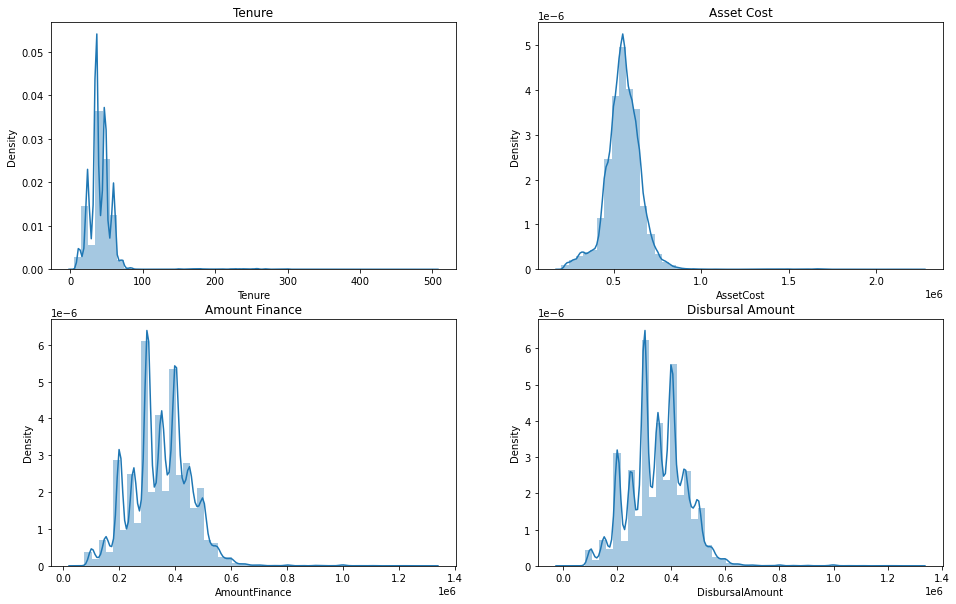

In [197]:
plt.figure(figsize = (16,10))
plt.subplot(221)
sn.distplot(main["Tenure"])
plt.title("Tenure")

plt.subplot(222)
sn.distplot(main["AssetCost"])
plt.title("Asset Cost")

plt.subplot(223)
sn.distplot(main["AmountFinance"])
plt.title("Amount Finance")

plt.subplot(224)
sn.distplot(main["DisbursalAmount"])
plt.title("Disbursal Amount")

plt.show()

<b>The distributions are heavily right skewed.

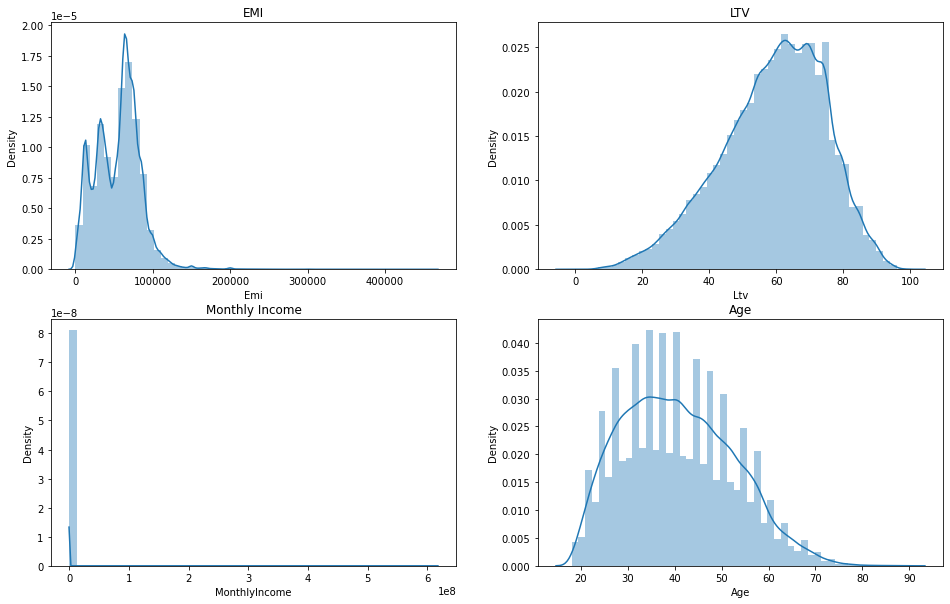

In [198]:
plt.figure(figsize = (16,10))
plt.subplot(221)
sn.distplot(main["Emi"])
plt.title("EMI")

plt.subplot(222)
sn.distplot(main["Ltv"])
plt.title("LTV")

plt.subplot(223)
sn.distplot(main["MonthlyIncome"])
plt.title("Monthly Income")

plt.subplot(224)
sn.distplot(main["Age"])
plt.title("Age")

plt.show()

<b>The skewness in age and LTV (Loan to Value) plots is very less whereas the monthly income and EMI columns are heavily skewed.</b> <br><br>
<b><u>Suggested Actions</u></b><br>
- Either remove the outliers to remove skewness 
- or come up with a transformation technique to normalize the feature values 
- or simply create categorical bins.

In [301]:
main.select_dtypes(include ="number").describe()

,Tenure,AssetCost,AmountFinance,DisbursalAmount,MonthlyIncomeLessEmi,Emi,Disbursal_year,Maturity_year,Ltv,Age,PartOfIncomePaidAsEmi,MonthlyIncome,Currentbal,Overdueamt,ReportedMonths,CountOfDpd,AmtOverdueMonths
count,128654.0000,1.2865e+05,1.2865e+05,1.2865e+05,1.2865e+05,128654.0000,128654.0000,128654.0000,128654.0000,128654.0000,1.2865e+05,1.2865e+05,1.2865e+05,128654.0000,128654.0000,128654.0000,128654.0000
mean,42.4648,5.5503e+05,3.4831e+05,3.4793e+05,-4.7759e+03,55073.1866,2014.5992,2017.8866,59.1261,40.6645,1.1908e+05,5.0297e+04,3.9406e+04,802.7695,28.3897,4.8047,27.7643
std,23.5341,1.0830e+05,1.0555e+05,1.0532e+05,1.7232e+06,28909.8164,2.4829,2.7190,15.5390,11.7102,3.3024e+06,1.7230e+06,7.8856e+04,6984.2786,10.1142,7.8899,10.0095
min,5.0000,2.0000e+05,5.0000e+04,2.8940e+03,-4.2333e+05,100.0000,2010.0000,2010.0000,-1.3800,18.0000,0.0000e+00,0.0000e+00,0.0000e+00,0.0000,0.0000,0.0000,0.0000
25%,36.0000,5.0000e+05,2.9000e+05,2.9000e+05,-3.6667e+04,32500.0000,2013.0000,2016.0000,49.1400,31.0000,7.7922e+01,2.5000e+04,0.0000e+00,0.0000,24.0000,0.0000,23.0000
50%,36.0000,5.5075e+05,3.5000e+05,3.5000e+05,-1.5533e+04,59700.0000,2015.0000,2018.0000,60.7800,40.0000,1.4176e+02,3.5833e+04,0.0000e+00,0.0000,34.0000,0.0000,33.0000
75%,48.0000,6.1100e+05,4.1000e+05,4.1000e+05,8.6913e+03,73800.0000,2017.0000,2020.0000,70.5900,49.0000,2.2029e+02,5.0000e+04,2.7475e+04,0.0000,36.0000,7.0000,35.0000
max,501.0000,2.2500e+06,1.3084e+06,1.3084e+06,6.1744e+08,460000.0000,2019.0000,2059.0000,100.0000,90.0000,2.5000e+08,6.1748e+08,3.3338e+06,281000.0000,36.0000,36.0000,36.0000


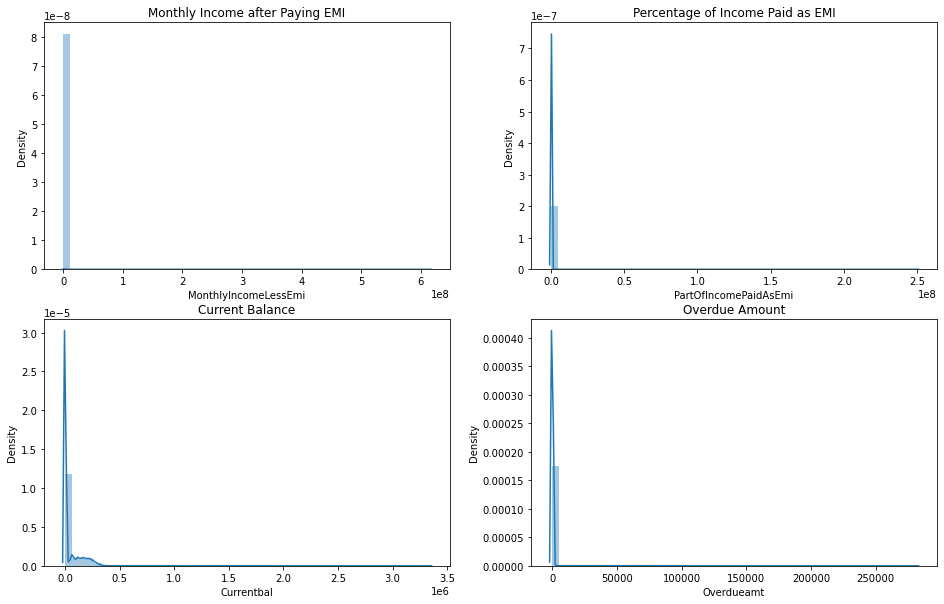

In [305]:
plt.figure(figsize = (16,10))
plt.subplot(221)
sn.distplot(main["MonthlyIncomeLessEmi"])
plt.title("Monthly Income after Paying EMI")

plt.subplot(222)
sn.distplot(main["PartOfIncomePaidAsEmi"])
plt.title("Percentage of Income Paid as EMI")

plt.subplot(223)
sn.distplot(main["Currentbal"])
plt.title("Current Balance")

plt.subplot(224)
sn.distplot(main["Overdueamt"])
plt.title("Overdue Amount")

plt.show()

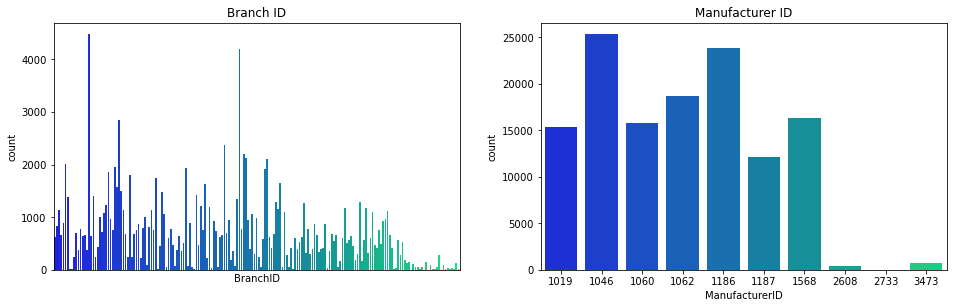

In [307]:
plt.figure(figsize = (16,10))
plt.subplot(221)
sn.countplot(main["BranchID"], palette = "winter")
plt.xticks([])
plt.title("Branch ID")

plt.subplot(222)
sn.countplot(main["ManufacturerID"], palette = "winter")
plt.title("Manufacturer ID")

plt.show()

<b>Observations</b><br>
- Majority of the customers are coming from a small number of branches.
- 7 out of 10 manufacturers are bringing almost 99% of the customers.


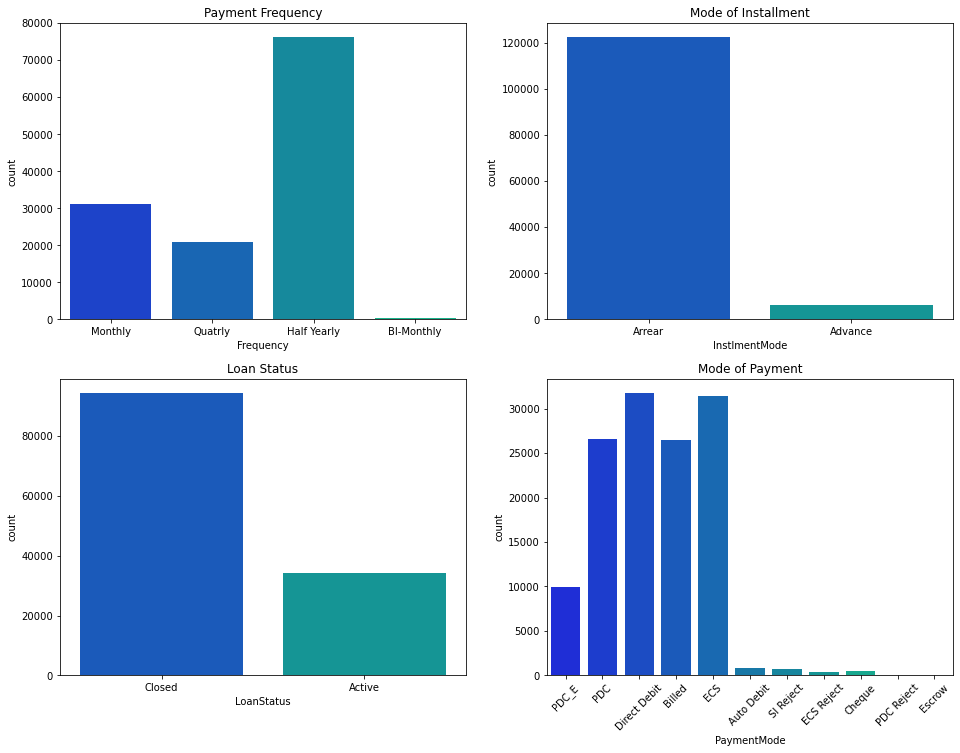

In [308]:
plt.figure(figsize = (16,12))
plt.subplot(221)
sn.countplot(main["Frequency"], palette = "winter")
plt.title("Payment Frequency")

plt.subplot(222)
sn.countplot(main["InstlmentMode"], palette = "winter")
plt.title("Mode of Installment")

plt.subplot(223)
sn.countplot(main["LoanStatus"], palette = "winter")
plt.title("Loan Status")


plt.subplot(224)
sn.countplot(main["PaymentMode"], palette = "winter")
plt.title("Mode of Payment")
plt.xticks(rotation = 45)

plt.show()

<b>Observations</b>
- More than 50% of the loan installments are being paid off half yearly.
- Approximately 90% of the chose arrear as the choice of making installments.
- Maximum of loan applications have already been closed.
- Post Dated cheques, Direct debit, electronic transfer and billed are the most preferred mode of payments for the loan.

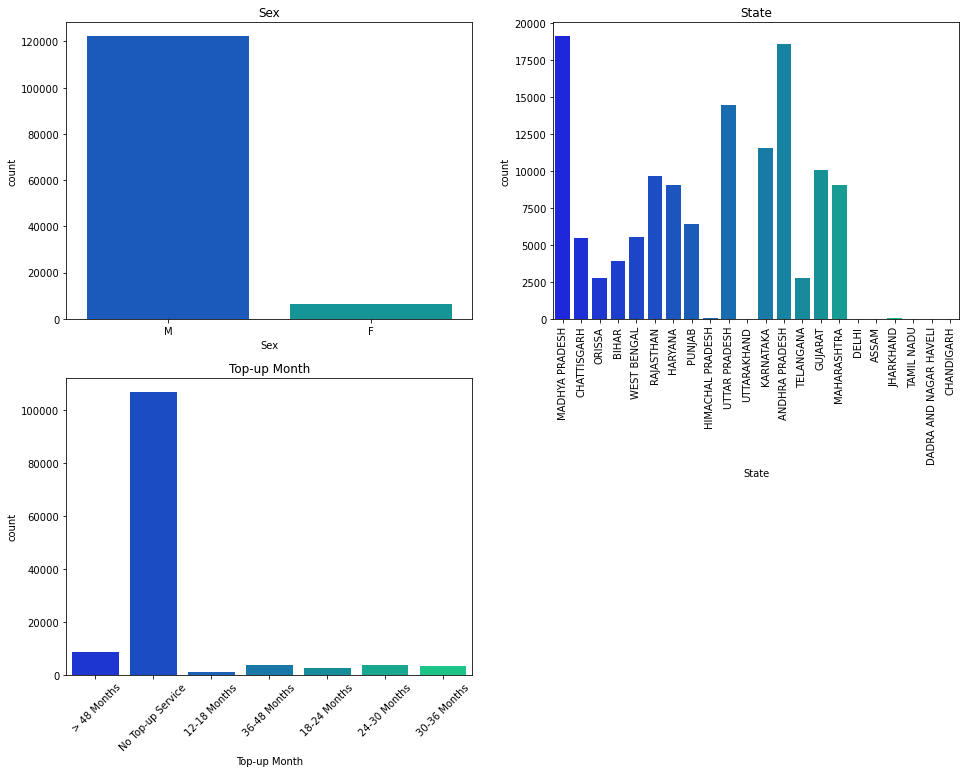

In [309]:
plt.figure(figsize = (16,12))

plt.subplot(221)
sn.countplot(main["Sex"], palette = "winter")
plt.title("Sex")

plt.subplot(222)
sn.countplot(main["State"], palette = "winter")
plt.xticks(rotation = 90)
plt.title("State")


plt.subplot(223)
sn.countplot(main["Top-up Month"], palette = "winter")
plt.title("Top-up Month")
plt.xticks(rotation = 45)

plt.show()

<b>Observations</b>
- The dataset is highly imbalanced as more than 80% of the customers did not avail top-up service.
- Females constitute only a small percentage of loan applicants i.e majority of the customers are males.
- The maximum number of customers are from Madhya Pradesh followed by Andhra Pradesh and Uttar Pradesh.

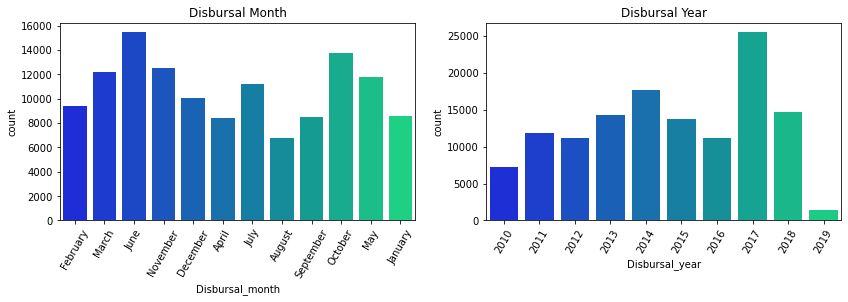

In [310]:
plt.figure(figsize = (14,8))

plt.subplot(221)
sn.countplot(main["Disbursal_month"], palette = "winter")
plt.title("Disbursal Month")
plt.xticks(rotation = 60)

plt.subplot(222)
sn.countplot(main["Disbursal_year"], palette = "winter")
plt.xticks(rotation = 60)
plt.title("Disbursal Year")

plt.show()

<b>Observations</b>
- The highest number of loan disbursal were in June followed by October. There appears to be a sinusoidal pattern in the dibursements.
- The company did maximum number of disbursals in 2017 and minimum in 2019.

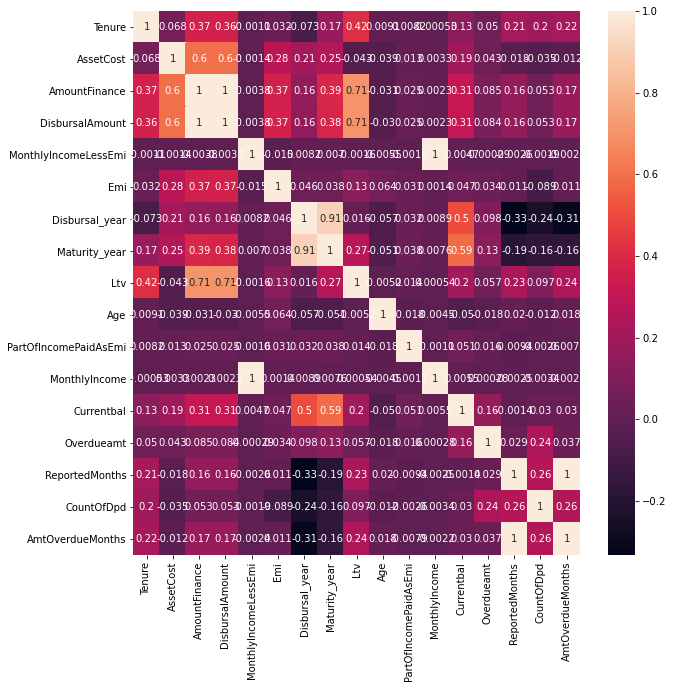

In [311]:
plt.figure(figsize = (10,10))
sn.heatmap(main.corr(), annot = True)
plt.show()